<a href="https://colab.research.google.com/github/m0hza/Brain_Cancer/blob/main/brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: mount my drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pydicom


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 40.4 MB/s eta 0:00:00


In [ ]:
# 🧠 Full U-Net Brain Tumor Segmentation on DICOM Data
#install neccessary libraries

import os
import cv2
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# Paths
img_dir = "/content/drive/MyDrive/MR/image_MR"  # Change to your full path if needed
mask_dir = "/content/drive/MyDrive/MR/mask_MR"

# Load and preprocess DICOM images and masks
def load_dicom_images(img_dir, mask_dir, size=(256, 256)):
    img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".dcm")])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(".dcm")])
    images, masks = [], []

    for img_file, mask_file in zip(img_files, mask_files):
        img = pydicom.dcmread(os.path.join(img_dir, img_file)).pixel_array
        mask = pydicom.dcmread(os.path.join(mask_dir, mask_file)).pixel_array

        # Resize to 256x256
        img = cv2.resize(img, size)
        mask = cv2.resize(mask, size)

        # Normalize and reshape
        img = img.astype('float32') / np.max(img)
        mask = (mask > 0).astype(np.float32)

        # Ensure correct shape: (256, 256, 1)
        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=-1)
        if len(mask.shape) == 2:
            mask = np.expand_dims(mask, axis=-1)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)


# Load data
X, y = load_dicom_images(img_dir, mask_dir)

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# U-Net model
def build_unet(input_shape):
    inputs = layers.Input(input_shape)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    u1 = layers.UpSampling2D()(c3)
    u1 = layers.Concatenate()([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.Concatenate()([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)
    return models.Model(inputs, outputs)

model = build_unet((256, 256, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=4)

# Visualize prediction
pred = model.predict(X_val[:1])[0, :, :, 0]
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(X_val[0].squeeze(), cmap='gray'); plt.title("Input MR")
plt.subplot(1,3,2); plt.imshow(y_val[0].squeeze(), cmap='gray'); plt.title("True Mask")
plt.subplot(1,3,3); plt.imshow(pred > 0.5, cmap='gray'); plt.title("Predicted Mask")
plt.tight_layout(); plt.show()


Epoch 1/10


ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "conv2d_11" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (4, 256, 256, 3)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(4, 256, 256, 3), dtype=float32)
  • training=True
  • mask=None

🛠️ STEP 1: PREPARE THE DATA
Scanning directories...
Found 90 DICOM files in image directory
Found 90 DICOM files in mask directory


Matching files: 100%|██████████| 90/90 [00:00<00:00, 5745.01it/s]


Successfully matched 6 image-mask pairs
Total files to process: 6
Loading data...


Loading data: 100%|██████████| 6/6 [00:00<00:00, 103.18it/s]

Successfully loaded 6 samples
Loaded 6 images
Image shape: (6, 256, 256)
Mask shape: (6, 256, 256)
Masks with content: 6/6
Consider getting more data or using a pre-trained model.
Training samples: 4
Validation samples: 2

🧠 STEP 2: TRAIN A SEGMENTATION MODEL
Using batch size: 4
DataGenerator initialized with 4 samples, batch size: 4
DataGenerator initialized with 2 samples, batch size: 2


Model summary:


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_136 (Conv2D) │ (None, 256, 256,  │        640 │ input_layer_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_54          │ (None, 256, 256,  │          0 │ conv2d_136[0][0]  │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_137 (Conv2D) │ (None, 256, 256,  │     36,928 │ dropout_54[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 128, 128,  │          0 │ conv2d_137[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_138 (Conv2D) │ (None, 128, 128,  │     73,856 │ max_pooling2d_28… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_55          │ (None, 128, 128,  │          0 │ conv2d_138[0][0]  │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_139 (Conv2D) │ (None, 128, 128,  │    147,584 │ dropout_55[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 64, 64,    │          0 │ conv2d_139[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_140 (Conv2D) │ (None, 64, 64,    │    295,168 │ max_pooling2d_29… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_56          │ (None, 64, 64,    │          0 │ conv2d_140[0][0]  │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_141 (Conv2D) │ (None, 64, 64,    │    590,080 │ dropout_56[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 32, 32,    │          0 │ conv2d_141[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_142 (Conv2D) │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_30… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_57          │ (None, 32, 32,    │          0 │ conv2d_142[0][0]  │
│ (Dropout)           │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_143 (Conv2D) │ (None, 32, 32,    │  2,359,808 │ dropout_57[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 16, 16,    │          0 │ conv2d_143[0][0]

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

Training for 10 epochs
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.3895 - dice_coefficient: 0.6568 - iou_score: 0.4890 - loss: 1.0295
Epoch 1: val_dice_coefficient improved from -inf to 0.66708, saving model to best_brain_tumor_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - accuracy: 0.3895 - dice_coefficient: 0.6568 - iou_score: 0.4890 - loss: 1.0295 - val_accuracy: 1.0000 - val_dice_coefficient: 0.6671 - val_iou_score: 0.5005 - val_loss: 1.0251 - learning_rate: 1.0000e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.9368 - dice_coefficient: 0.6733 - iou_score: 0.5075 - loss: 0.9849
Epoch 2: val_dice_coefficient improved from 0.66708 to 0.66770, saving model to best_brain_tumor_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.9368 - dice_coefficient: 0.6733 - iou_score: 0.5075 - loss: 0.9849 - val_accuracy: 1.0000 - val_dice_coefficient: 0.6677 - val_iou_score: 0.5012 - val_loss: 1.0231 - learning_rate: 1.0000e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9639 - dice_coefficient: 0.6678 - iou_score: 0.5013 - loss: 1.0060
Epoch 3: val_dice_coefficient improved from 0.66770 to 0.66866, saving model to best_brain_tumor_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.9639 - dice_coefficient: 0.6678 - iou_score: 0.5013 - loss: 1.0060 - val_accuracy: 1.0000 - val_dice_coefficient: 0.6687 - val_iou_score: 0.5022 - val_loss: 1.0200 - learning_rate: 1.0000e-04
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9608 - dice_coefficient: 0.6600 - iou_score: 0.4925 - loss: 1.0284
Epoch 4: val_dice_coefficient improved from 0.66866 to 0.67028, saving model to best_brain_tumor_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9608 - dice_coefficient: 0.6600 - iou_score: 0.4925 - loss: 1.0284 - val_accuracy: 1.0000 - val_dice_coefficient: 0.6703 - val_iou_score: 0.5041 - val_loss: 1.0147 - learning_rate: 1.0000e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9735 - dice_coefficient: 0.7332 - iou_score: 0.5788 - loss: 0.8169
Epoch 5: val_dice_coefficient improved from 0.67028 to 0.67358, saving model to best_brain_tumor_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.9735 - dice_coefficient: 0.7332 - iou_score: 0.5788 - loss: 0.8169 - val_accuracy: 1.0000 - val_dice_coefficient: 0.6736 - val_iou_score: 0.5078 - val_loss: 1.0041 - learning_rate: 1.0000e-04
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9350 - dice_coefficient: 0.6621 - iou_score: 0.4949 - loss: 1.0092
Epoch 6: val_dice_coefficient improved from 0.67358 to 0.68088, saving model to best_brain_tumor_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9350 - dice_coefficient: 0.6621 - iou_score: 0.4949 - loss: 1.0092 - val_accuracy: 1.0000 - val_dice_coefficient: 0.6809 - val_iou_score: 0.5162 - val_loss: 0.9805 - learning_rate: 1.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9354 - dice_coefficient: 0.6766 - iou_score: 0.5113 - loss: 0.9654
Epoch 7: val_dice_coefficient improved from 0.68088 to 0.70060, saving model to best_brain_tumor_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.9354 - dice_coefficient: 0.6766 - iou_score: 0.5113 - loss: 0.9654 - val_accuracy: 1.0000 - val_dice_coefficient: 0.7006 - val_iou_score: 0.5392 - val_loss: 0.9174 - learning_rate: 1.0000e-04
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.9404 - dice_coefficient: 0.7959 - iou_score: 0.6610 - loss: 0.6524
Epoch 8: val_dice_coefficient improved from 0.70060 to 0.75655, saving model to best_brain_tumor_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.9404 - dice_coefficient: 0.7959 - iou_score: 0.6610 - loss: 0.6524 - val_accuracy: 1.0000 - val_dice_coefficient: 0.7565 - val_iou_score: 0.6084 - val_loss: 0.7422 - learning_rate: 1.0000e-04
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9459 - dice_coefficient: 0.8522 - iou_score: 0.7424 - loss: 2.0359
Epoch 9: val_dice_coefficient did not improve from 0.75655
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9459 - dice_coefficient: 0.8522 - iou_score: 0.7424 - loss: 2.0359 - val_accuracy: 1.0000 - val_dice_coefficient: 0.7368 - val_iou_score: 0.5832 - val_loss: 0.8036 - learning_rate: 1.0000e-04
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9705 - dice_coefficient: 0.9383 - iou_score: 0.8838 - loss: 0.3301
Epoch 10: val_dice_coefficient did not improve from 0.75655
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.9705 - dice_coefficient: 0.9383 - iou_score: 0.8838 - loss: 0.3301 - val_accur

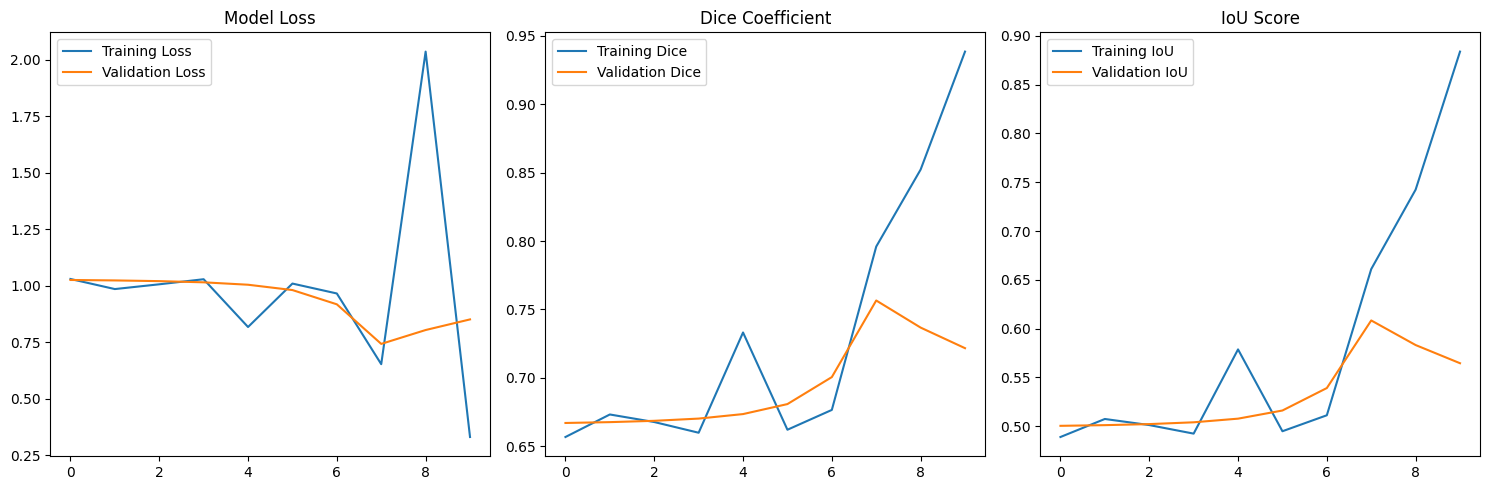


🧨 STEP 4: INFER AND VISUALIZE
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


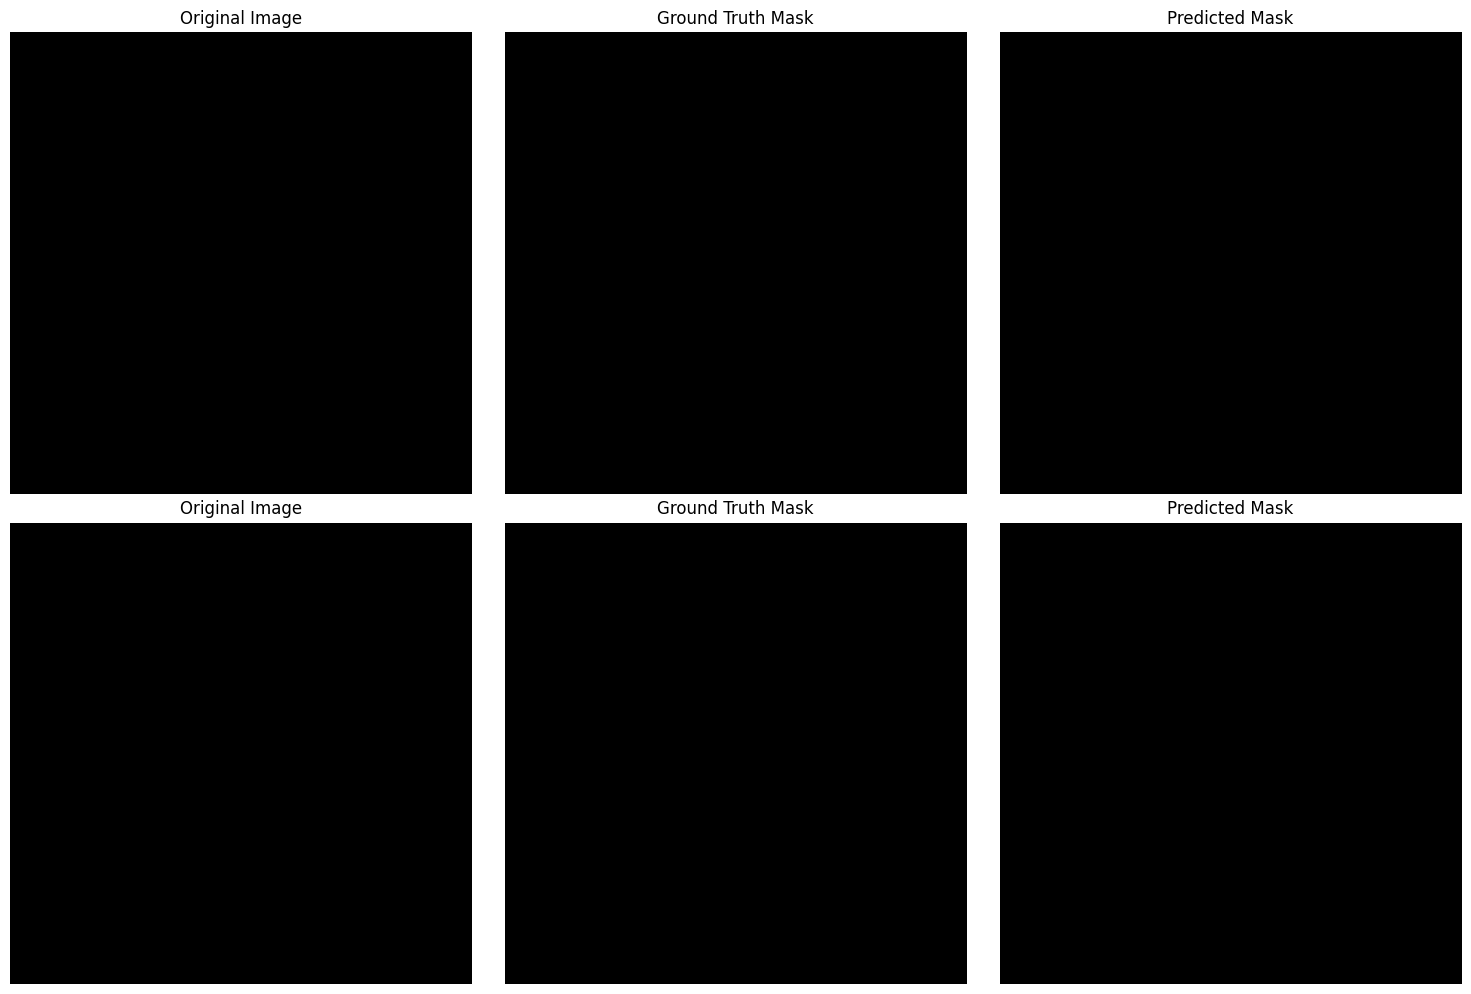

Training completed successfully!
Model saved as 'best_brain_tumor_model.h5'


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from sklearn.model_selection import train_test_split
import pydicom
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Deep Learning imports
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import Sequence
import albumentations as A

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class DICOMDataLoader:
    """
    Class to handle DICOM file loading and preprocessing
    """
    def __init__(self, image_dir, mask_dir=None, target_size=(256, 256)):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir) if mask_dir else None
        self.target_size = target_size
        self.image_paths = []
        self.mask_paths = []

    def load_dicom_image(self, dicom_path):
        """Load and preprocess DICOM image"""
        try:
            dicom = pydicom.dcmread(dicom_path)
            image = dicom.pixel_array.astype(np.float32)

            # Handle different DICOM formats
            if len(image.shape) == 3:
                image = image[0]  # Take first slice if 3D

            # Normalize to 0-255 range
            if image.max() > image.min():  # Avoid division by zero
                image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)
            else:
                image = np.zeros_like(image, dtype=np.uint8)

            # Resize to target size
            image = cv2.resize(image, self.target_size)

            return image
        except Exception as e:
            print(f"Error loading {dicom_path}: {e}")
            return None

    def load_dicom_mask(self, mask_path):
        """Load and preprocess DICOM mask"""
        try:
            dicom = pydicom.dcmread(mask_path)
            mask = dicom.pixel_array.astype(np.float32)

            # Handle different DICOM formats
            if len(mask.shape) == 3:
                mask = mask[0]  # Take first slice if 3D

            # Binarize mask
            mask = (mask > 0).astype(np.uint8)

            # Resize to target size
            mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)

            return mask
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            return None

    def scan_directory(self):
        """Scan directories and match images with masks"""
        print("Scanning directories...")

        # Check if directories exist
        if not self.image_dir.exists():
            print(f"Image directory does not exist: {self.image_dir}")
            return 0

        if self.mask_dir and not self.mask_dir.exists():
            print(f"Mask directory does not exist: {self.mask_dir}")
            return 0

        # Get all DICOM files from image directory
        image_files = list(self.image_dir.glob("*.dcm"))
        print(f"Found {len(image_files)} DICOM files in image directory")

        if len(image_files) == 0:
            print("No DICOM files found in image directory!")
            return 0

        if self.mask_dir:
            mask_files = list(self.mask_dir.glob("*.dcm"))
            print(f"Found {len(mask_files)} DICOM files in mask directory")

            # Match images with masks based on filename
            matched_pairs = 0
            for img_file in tqdm(image_files, desc="Matching files"):
                img_name = img_file.stem

                # Look for corresponding mask
                mask_file = None
                for mask in mask_files:
                    if img_name in mask.stem or mask.stem in img_name:
                        mask_file = mask
                        break

                if mask_file:
                    self.image_paths.append(img_file)
                    self.mask_paths.append(mask_file)
                    matched_pairs += 1

            print(f"Successfully matched {matched_pairs} image-mask pairs")
        else:
            # No masks provided - inference mode
            self.image_paths = image_files
            self.mask_paths = [None] * len(image_files)

        print(f"Total files to process: {len(self.image_paths)}")
        return len(self.image_paths)

    def load_data(self, limit=None):
        """Load all data into memory"""
        images = []
        masks = []

        n_samples = min(limit, len(self.image_paths)) if limit else len(self.image_paths)

        successful_loads = 0
        for i in tqdm(range(n_samples), desc="Loading data"):
            # Load image
            img = self.load_dicom_image(self.image_paths[i])
            if img is not None:
                images.append(img)

                # Load mask if available
                if self.mask_paths[i]:
                    mask = self.load_dicom_mask(self.mask_paths[i])
                    masks.append(mask if mask is not None else np.zeros(self.target_size, dtype=np.uint8))
                else:
                    masks.append(np.zeros(self.target_size, dtype=np.uint8))

                successful_loads += 1

        print(f"Successfully loaded {successful_loads} samples")
        return np.array(images, dtype=np.uint8), np.array(masks, dtype=np.float32)

class DataGenerator(Sequence):
    """
    Data generator for training with augmentation
    """
    def __init__(self, images, masks, batch_size=8, augment=True):
        self.images = images
        self.masks = masks
        self.batch_size = min(batch_size, len(images))  # Ensure batch size doesn't exceed dataset size
        self.augment = augment
        self.indices = np.arange(len(images))

        print(f"DataGenerator initialized with {len(images)} samples, batch size: {self.batch_size}")

        # Define augmentation pipeline
        if augment:
            self.aug_pipeline = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.2),
                A.RandomRotate90(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                A.GaussianBlur(blur_limit=3, p=0.3),
            ])

        self.on_epoch_end()

    def __len__(self):
        if len(self.images) == 0:
            return 0
        return max(1, len(self.images) // self.batch_size)

    def __getitem__(self, index):
        # Handle case where we might go beyond available indices
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.images))
        batch_indices = self.indices[start_idx:end_idx]

        actual_batch_size = len(batch_indices)

        batch_images = np.zeros((actual_batch_size, *self.images.shape[1:], 1))
        batch_masks = np.zeros((actual_batch_size, *self.masks.shape[1:], 1))

        for i, idx in enumerate(batch_indices):
            image = self.images[idx].copy()
            mask = self.masks[idx].copy()

            # Apply augmentation
            if self.augment:
                try:
                    augmented = self.aug_pipeline(image=image, mask=mask)
                    image = augmented['image']
                    mask = augmented['mask']
                except Exception as e:
                    print(f"Augmentation failed for sample {idx}: {e}")
                    # Continue with original image/mask

            # Normalize image
            image = image.astype(np.float32) / 255.0
            mask = mask.astype(np.float32)

            batch_images[i] = np.expand_dims(image, axis=-1)
            batch_masks[i] = np.expand_dims(mask, axis=-1)

        return batch_images, batch_masks

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

def build_unet(input_shape=(256, 256, 1), n_classes=1):
    """
    Build U-Net architecture for segmentation
    """
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = layers.Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


def combined_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice


def iou_score(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


def visualize_results(images, masks, predictions, n_samples=4):
    """Visualize segmentation results"""
    n_samples = min(n_samples, len(images))
    fig, axes = plt.subplots(n_samples, 3, figsize=(15, 5*n_samples))

    # Handle case with single sample
    if n_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(n_samples):
        # Original image
        axes[i, 0].imshow(images[i].squeeze(), cmap='gray')
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # Ground truth mask
        axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')

        # Predicted mask
        axes[i, 2].imshow(predictions[i].squeeze(), cmap='gray')
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

def main():
    """Main training pipeline"""

    # 🛠️ STEP 1: PREPARE THE DATA
    print("=" * 50)
    print("🛠️ STEP 1: PREPARE THE DATA")
    print("=" * 50)

    # Initialize data loader
    image_dir = "/content/drive/MyDrive/MR/image_MR"
    mask_dir = "/content/drive/MyDrive/MR/mask_MR"  # Adjust path as needed

    loader = DICOMDataLoader(image_dir, mask_dir, target_size=(256, 256))

    # Scan directories
    n_files = loader.scan_directory()

    if n_files == 0:
        print("No DICOM files found! Please check your paths.")
        print(f"Image directory: {image_dir}")
        print(f"Mask directory: {mask_dir}")
        return

    # Load data
    print("Loading data...")


    images, masks = loader.load_data(limit=None)  # Remove limit to load all data
    masks = masks.astype(np.float32)
    if len(images) == 0:
        print("No images were successfully loaded!")
        return

    print(f"Loaded {len(images)} images")
    print(f"Image shape: {images.shape}")
    print(f"Mask shape: {masks.shape}")

    # Check for masks with content
    mask_content = masks.sum(axis=(1,2))
    positive_masks = (mask_content > 0).sum()
    print(f"Masks with content: {positive_masks}/{len(masks)}")

    # Ensure we have enough data for training
    if len(images) < 10:
        print(f"Warning: Only {len(images)} samples available. This is very small for deep learning.")
        print("Consider getting more data or using a pre-trained model.")

    # Split data - handle case with very few samples
    if len(images) > 1:
        # For stratification, ensure we have both positive and negative samples
        if positive_masks > 0 and positive_masks < len(masks):
            stratify_labels = mask_content > 0
        else:
            stratify_labels = None

        test_size = max(0.1, min(0.2, 2/len(images)))  # At least 1 sample for validation

        train_imgs, val_imgs, train_masks, val_masks = train_test_split(
            images, masks, test_size=test_size, random_state=42,
            stratify=stratify_labels
        )
    else:
        # Only one sample - use it for both training and validation
        train_imgs = val_imgs = images
        train_masks = val_masks = masks

    print(f"Training samples: {len(train_imgs)}")
    print(f"Validation samples: {len(val_imgs)}")

    # 🧠 STEP 2: TRAIN A SEGMENTATION MODEL
    print("\n" + "=" * 50)
    print("🧠 STEP 2: TRAIN A SEGMENTATION MODEL")
    print("=" * 50)

    # Adjust batch size based on available data
    batch_size = min(8, len(train_imgs))
    print(f"Using batch size: {batch_size}")

    # Create data generators
    train_gen = DataGenerator(train_imgs, train_masks, batch_size=batch_size, augment=True)
    val_gen = DataGenerator(val_imgs, val_masks, batch_size=batch_size, augment=False)

    # Check if generators have data
    if len(train_gen) == 0:
        print("Training generator is empty! Cannot proceed with training.")
        return

    # Build model
    model = build_unet(input_shape=(256, 256, 1))

    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss=combined_loss,
        metrics=[dice_coefficient, iou_score, 'accuracy']
    )

    print("Model summary:")
    model.summary()

    # Define callbacks
    checkpoint = callbacks.ModelCheckpoint(
        'best_brain_tumor_model.h5',
        monitor='val_dice_coefficient',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    early_stopping = callbacks.EarlyStopping(
        monitor='val_dice_coefficient',
        patience=15,
        mode='max',
        restore_best_weights=True
    )

    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_dice_coefficient',
        factor=0.5,
        patience=7,
        mode='max',
        min_lr=1e-7,
        verbose=1
    )

    # Adjust epochs based on dataset size
    epochs = min(100, max(10, len(train_imgs) * 2))
    print(f"Training for {epochs} epochs")

    # Train model
    try:
        history = model.fit(
            train_gen,
            epochs=epochs,
            validation_data=val_gen,
            callbacks=[checkpoint, early_stopping, reduce_lr],
            verbose=1
        )
    except Exception as e:
        print(f"Training failed: {e}")
        return

    # 🧪 STEP 3: VALIDATE & TEST
    print("\n" + "=" * 50)
    print("🧪 STEP 3: VALIDATE & TEST")
    print("=" * 50)

    # Load best model if checkpoint was saved
    try:
        model.load_weights('best_brain_tumor_model.h5')
        print("Loaded best model weights")
    except:
        print("Using current model weights (checkpoint may not have been saved)")

    # Evaluate on validation set
    val_loss, val_dice, val_iou, val_acc = model.evaluate(val_gen, verbose=0)

    print(f"Validation Results:")
    print(f"Loss: {val_loss:.4f}")
    print(f"Dice Coefficient: {val_dice:.4f}")
    print(f"IoU Score: {val_iou:.4f}")
    print(f"Accuracy: {val_acc:.4f}")

    # Plot training history
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history.history['dice_coefficient'], label='Training Dice')
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice')
    plt.title('Dice Coefficient')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history.history['iou_score'], label='Training IoU')
    plt.plot(history.history['val_iou_score'], label='Validation IoU')
    plt.title('IoU Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 🧨 STEP 4: INFER AND VISUALIZE
    print("\n" + "=" * 50)
    print("🧨 STEP 4: INFER AND VISUALIZE")
    print("=" * 50)

    # Make predictions on validation set
    predictions = model.predict(val_gen, verbose=1)
    predictions = (predictions > 0.5).astype(np.uint8)

    # Visualize results
    n_vis = min(4, len(val_imgs))
    visualize_results(val_imgs[:n_vis], val_masks[:n_vis], predictions[:n_vis], n_samples=n_vis)

    print("Training completed successfully!")
    print("Model saved as 'best_brain_tumor_model.h5'")

def inference_pipeline(model_path, image_dir, output_dir=None):
    """
    Inference pipeline for new images
    """
    print("=" * 50)
    print("🔮 INFERENCE ON NEW IMAGES")
    print("=" * 50)

    # Load trained model
    model = models.load_model(model_path, custom_objects={
        'combined_loss': combined_loss,
        'dice_coefficient': dice_coefficient,
        'iou_score': iou_score
    })

    # Load new images
    loader = DICOMDataLoader(image_dir, mask_dir=None, target_size=(256, 256))
    n_files = loader.scan_directory()

    if n_files == 0:
        print("No images found for inference!")
        return None

    images, _ = loader.load_data()

    if len(images) == 0:
        print("No images were successfully loaded!")
        return None

    # Normalize images
    images_norm = images.astype(np.float32) / 255.0
    images_norm = np.expand_dims(images_norm, axis=-1)

    # Make predictions
    predictions = model.predict(images_norm, verbose=1)
    predictions = (predictions > 0.5).astype(np.uint8)

    # Visualize results
    n_vis = min(len(images), 4)
    fig, axes = plt.subplots(n_vis, 2, figsize=(10, 3*n_vis))

    if n_vis == 1:
        axes = axes.reshape(1, -1)

    for i in range(n_vis):
        # Original image
        axes[i, 0].imshow(images[i], cmap='gray')
        axes[i, 0].set_title(f'Original Image {i+1}')
        axes[i, 0].axis('off')

        # Predicted mask
        axes[i, 1].imshow(predictions[i].squeeze(), cmap='gray')
        axes[i, 1].set_title(f'Predicted Tumor Mask {i+1}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Save results if output directory is specified
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        for i, pred in enumerate(predictions):
            output_path = os.path.join(output_dir, f'prediction_{i+1}.png')
            cv2.imwrite(output_path, pred.squeeze() * 255)
        print(f"Predictions saved to {output_dir}")

    return predictions

if __name__ == "__main__":
    # Run the main training pipeline
    main()

    # Example usage for inference on new images:
    # predictions = inference_pipeline(
    #     model_path='best_brain_tumor_model.h5',
    #     image_dir='/path/to/new/images',
    #     output_dir='/path/to/save/results'
    # )

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
✅ S1.png — No ground truth mask found.


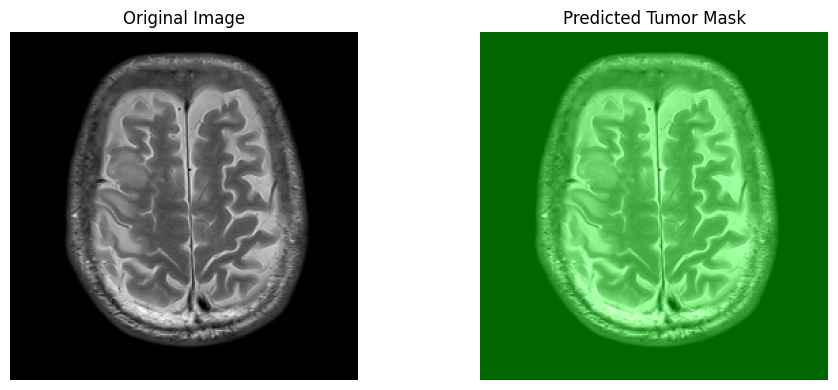

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
✅ S3.png — No ground truth mask found.


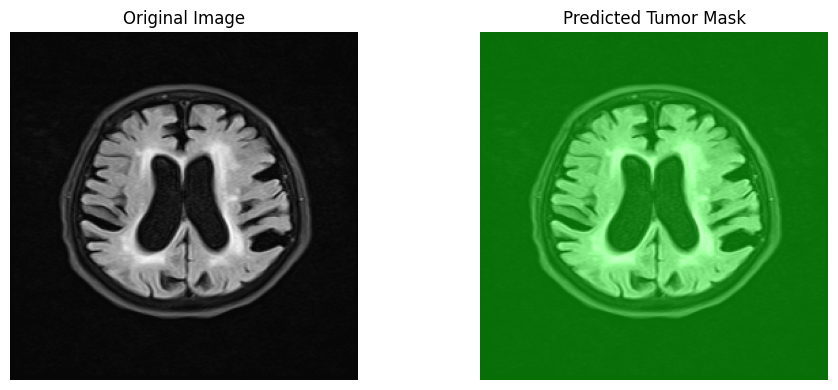

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
✅ S4.png — No ground truth mask found.


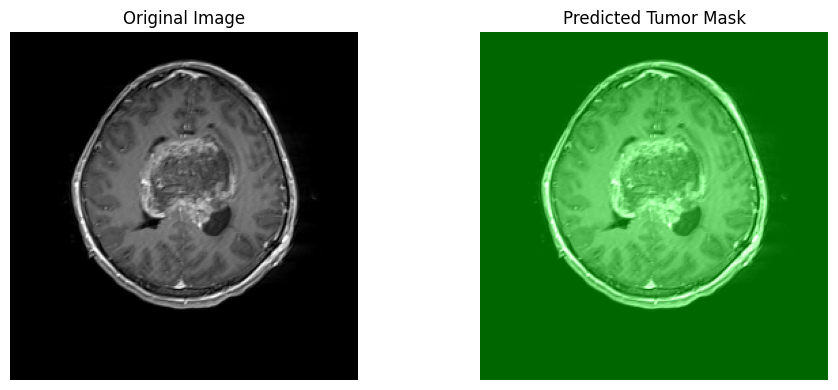

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
✅ S2.png — No ground truth mask found.


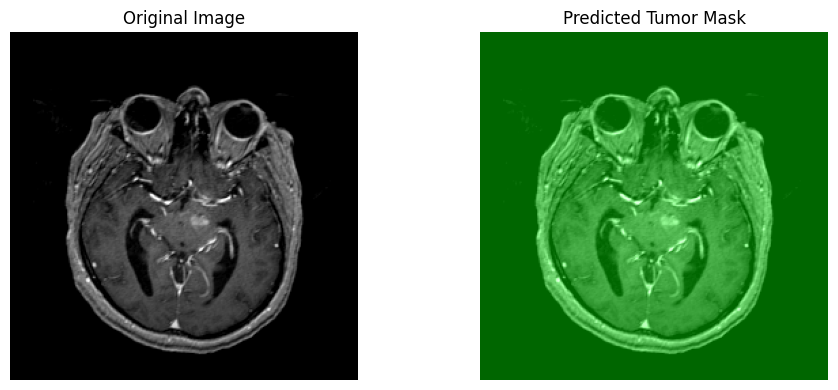

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
✅ S5.png — No ground truth mask found.


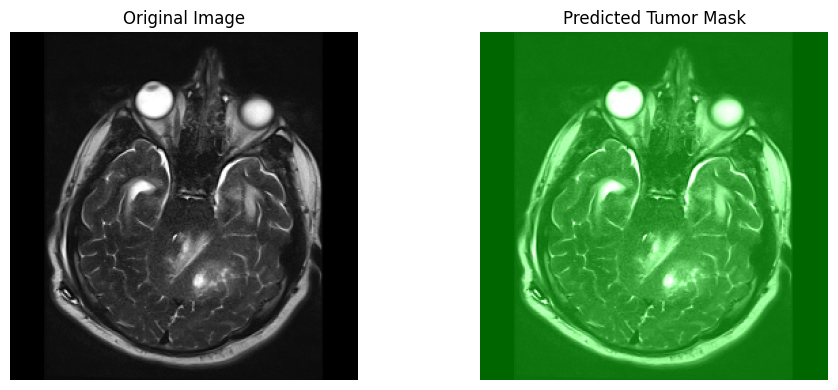

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# === CONFIG ===
model_path = "/content/best_brain_tumor_model.h5"
image_dir = "/content/testbrain"       # Folder of PNG brain images
mask_dir = os.path.join(image_dir, "masks")  # Ground truth masks
output_dir = "/content/drive/MyDrive/MR/png_results"  # Save predicted masks

# === FUNCTION: Load & preprocess PNGs ===
def load_png_image(path, target_size=(256, 256)):
    image = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0
    return np.expand_dims(image, axis=-1)

# === FUNCTION: Dice Score ===
def dice_score(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# === FUNCTION: Overlay mask on image ===
def overlay_mask(image, mask, alpha=0.4):
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    mask_colored = np.zeros_like(image_color)
    mask_colored[:, :, 1] = mask * 255  # green
    return cv2.addWeighted(image_color, 1.0, mask_colored, alpha, 0)

# === MAIN INFERENCE FUNCTION ===
def inference_png_pipeline(model_path, image_dir, output_dir):
    from pathlib import Path
    os.makedirs(output_dir, exist_ok=True)

    model = load_model(model_path, custom_objects={
        'combined_loss': lambda y_true, y_pred: y_pred,
        'dice_coefficient': lambda y_true, y_pred: y_pred,
        'iou_score': lambda y_true, y_pred: y_pred,
    })

    image_paths = list(Path(image_dir).glob("*.png"))
    if not image_paths:
        print("❌ No PNG files found in the folder.")
        return

    for i, img_path in enumerate(image_paths):
        img = load_png_image(img_path)
        input_img = np.expand_dims(img, axis=0)

        pred_mask = model.predict(input_img)[0]
        binary_mask = (pred_mask > 0.5).astype(np.uint8).squeeze()

        # Save predicted mask
        mask_path = os.path.join(output_dir, f"mask_{i+1}.png")
        cv2.imwrite(mask_path, binary_mask * 255)

        # Overlay
        img_uint8 = (img.squeeze() * 255).astype(np.uint8)
        overlay = overlay_mask(img_uint8, binary_mask)
        overlay_path = os.path.join(output_dir, f"overlay_{i+1}.png")
        cv2.imwrite(overlay_path, overlay)

        # 🎯 Calculate Dice if ground truth available
        ground_truth_path = os.path.join(mask_dir, img_path.name)
        if os.path.exists(ground_truth_path):
            true_mask = load_png_image(ground_truth_path).squeeze()
            true_mask = (true_mask > 0.5).astype(np.uint8)
            dice = dice_score(true_mask, binary_mask)
            print(f"✅ {img_path.name} — Dice Score: {dice:.4f}")
        else:
            print(f"✅ {img_path.name} — No ground truth mask found.")

        # Show results
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img_uint8, cmap='gray')
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(overlay)
        plt.title("Predicted Tumor Mask")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# 🔁 Run the pipeline
inference_png_pipeline(model_path, image_dir, output_dir)


In [ ]:
# === MAIN INFERENCE FUNCTION ===
def inference_png_pipeline(model_path, image_dir, output_dir):
    from pathlib import Path
    os.makedirs(output_dir, exist_ok=True)

    model = load_model(model_path, custom_objects={
        'combined_loss': lambda y_true, y_pred: y_pred,
        'dice_coefficient': lambda y_true, y_pred: y_pred,
        'iou_score': lambda y_true, y_pred: y_pred,
    })

    image_paths = list(Path(image_dir).glob("*.png"))
    if not image_paths:
        print("❌ No PNG files found in the folder.")
        return

    for i, img_path in enumerate(image_paths):
        img = load_png_image(img_path)
        input_img = np.expand_dims(img, axis=0)

        pred_mask = model.predict(input_img)[0]
        binary_mask = (pred_mask > 0.5).astype(np.uint8).squeeze()

        # Save predicted mask
        mask_path = os.path.join(output_dir, f"mask_{i+1}.png")
        cv2.imwrite(mask_path, binary_mask * 255)

        # Overlay
        img_uint8 = (img.squeeze() * 255).astype(np.uint8)
        overlay = overlay_mask(img_uint8, binary_mask)
        overlay_path = os.path.join(output_dir, f"overlay_{i+1}.png")
        cv2.imwrite(overlay_path, overlay)

        # 🎯 Calculate Dice if ground truth available
        ground_truth_path = os.path.join(mask_dir, img_path.name)
        dice = None
        if os.path.exists(ground_truth_path):
            true_mask = load_png_image(ground_truth_path).squeeze()
            true_mask = (true_mask > 0.5).astype(np.uint8)
            dice = dice_score(true_mask, binary_mask)
            print(f"✅ {img_path.name} — Dice Score: {dice:.4f}")
        else:
            print(f"✅ {img_path.name} — No ground truth mask found.")

        # Show results
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img_uint8, cmap='gray')
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(overlay)
        plt.title("Predicted Tumor Mask")
        plt.axis('off')

        if dice is not None:
            plt.text(5, 240, f'Dice: {dice:.4f}', color='white', fontsize=10, bbox=dict(facecolor='black', alpha=0.5))

        plt.tight_layout()
        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
✅ S1.png — No ground truth mask found.


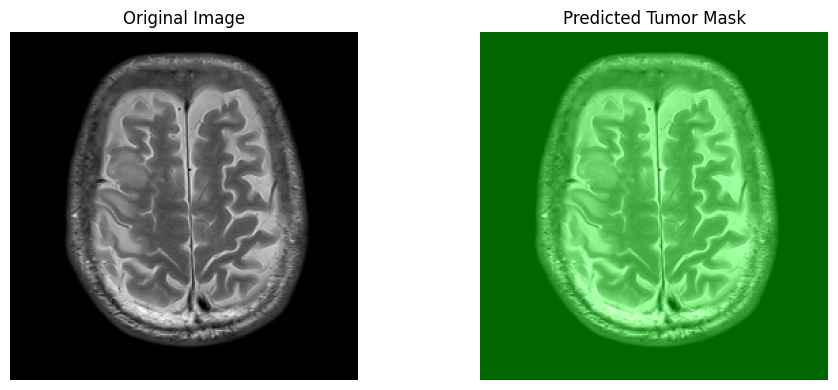

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
✅ S3.png — No ground truth mask found.


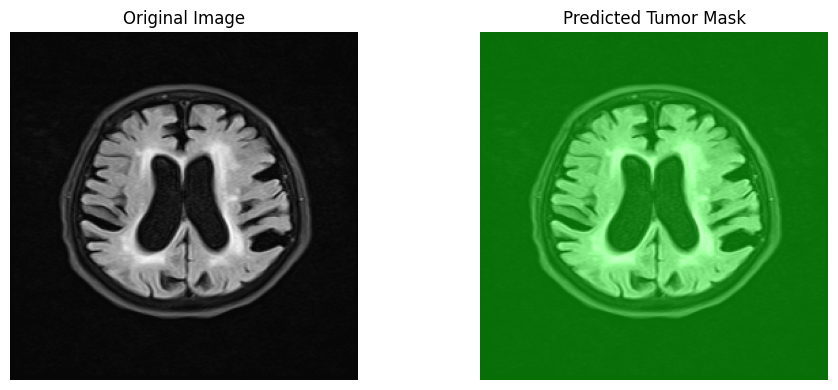

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
✅ S4.png — No ground truth mask found.


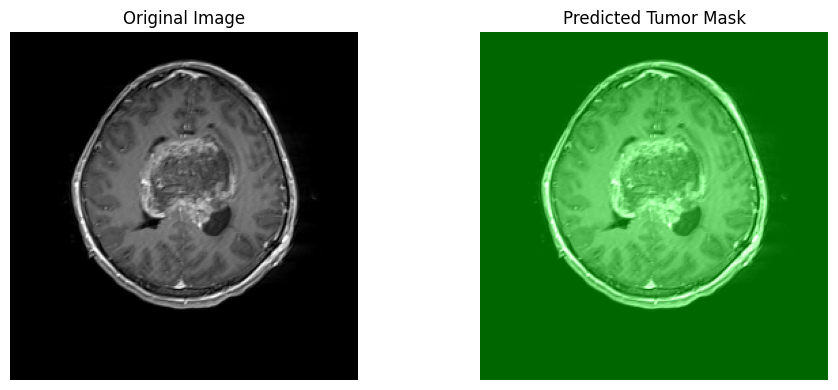

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
✅ S2.png — No ground truth mask found.


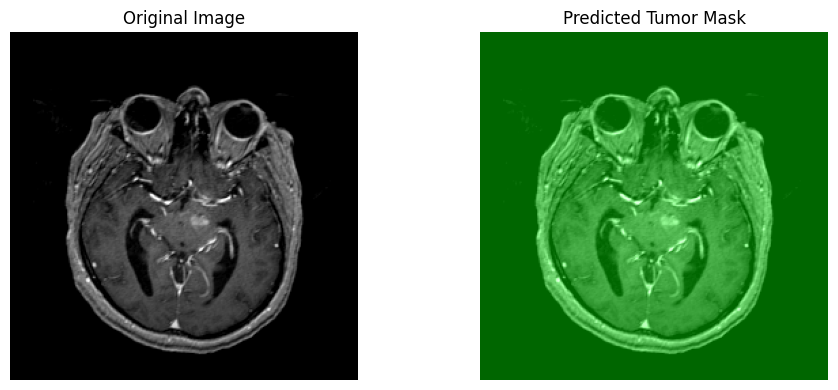

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
✅ S5.png — No ground truth mask found.


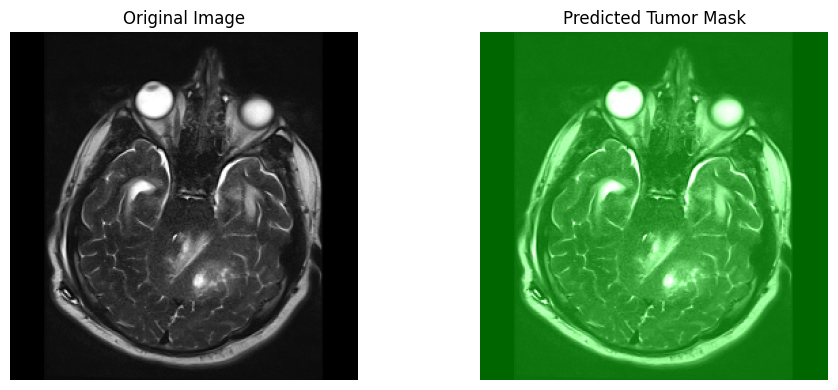

In [ ]:
# 🔁 Run inference and save pseudo-ground-truth masks
inference_png_pipeline(
    model_path=model_path,
    image_dir=image_dir,
    output_dir=output_dir
)
